In [9]:
import torch
import torchvision
import pathlib
import imageio
import os
import cv2
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch import nn
from PIL import Image
from torchvision import transforms
from itertools import islice
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
training_paths = []
for root, directories, filenames in os.walk('development'):
  for filename in filenames: 
    training_paths.append(os.path.join(root,filename))  

# split the dataset in train and validation set (holdout stratified)
# lab1 = np.ones((380,), dtype=int)
# lab2 = np.zeros((380, ), dtype=int)
# lab = np.concatenate((lab1, lab2))
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# split = skf.split(training_paths, lab)
# select = 0
# train_ix, val_ix = next(islice(split, select, select + 1))
# training_paths = np.array(training_paths)
# train_ids = training_paths[train_ix.astype(int)]
# valid_ids = training_paths[val_ix]

# split the dataset in train and validation set (use some folder for validation)
training_paths = np.array(training_paths)
train_ids1 = training_paths[0:250]
train_ids2 = training_paths[380: 630]
valid_ids1 = training_paths[250: 380]
valid_ids2 = training_paths[630: 760]
train_ids = np.concatenate((train_ids1, train_ids2))
valid_ids = np.concatenate((valid_ids1, valid_ids2))

class DataGenerator(Dataset):

  def __init__(self, images_path, augmentations=False):
    self.images_path = images_path
    self.augmentations = augmentations

  def __getitem__(self, index):
    im_path = self.images_path[index]
    input_image = Image.open(im_path)
    preprocess = None
    if self.augmentations:
      preprocess = transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(400),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.1),
        transforms.ColorJitter(brightness = 0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    else:
      preprocess = transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(400),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    input_tensor = preprocess(input_image)
    path = im_path.split("/")
    label = 0 if path[1] == "real" else 1
    return input_tensor, label, im_path

  def __len__(self):
    return len(self.images_path)



In [11]:
train_data = DataGenerator(train_ids, True)
train_data_loader = DataLoader(train_data,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

valid_data = DataGenerator(valid_ids, False)
valid_data_loader = DataLoader(valid_data,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

def validation_score(model, valid_data, device):
  tot_loss = 0
  model.eval()
  with torch.no_grad():
    for xb, yb, _ in valid_data:
      
      model.to(device)
      xb = xb.to(device)
      yb = yb.to(device)

      pred = model(xb)
      pred_label = torch.argmax(pred, dim=1)
      
      loss = loss_func(pred, yb)
      tot_loss += loss
      # alternative loss
      # for p, y in zip(pred_label, yb):
      #  if p!=y:
      #    tot_loss += 1

  return tot_loss/len(valid_ids)

In [12]:
# Model: resnet50 with a different classifier
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)

**Training**

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# settings
n_epochs = 8
lr = 0.0001
params = [p for p in model.parameters() if p.requires_grad]
opt = optim.Adam(params, lr=lr, weight_decay=0.1)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
vd_score = None

for epoch in range(n_epochs):
  tot_loss = 0
  model.train()
  
  for xb, yb, _ in train_data_loader:
    model.to(device)
    xb = xb.to(device)
    yb = yb.to(device)

    pred = model(xb)
    loss = loss_func(pred, yb)

    tot_loss += loss
    if opt is not None:
          loss.backward()
          opt.step()
          opt.zero_grad()
  
  if lr_scheduler is not None:
    lr_scheduler.step()
  print(f'Loss: {tot_loss / len(train_ids)}')
  val = validation_score(model, valid_data_loader, device)
  print(f'Val loss: {val}')

  # save best weights
  if vd_score is None or val < vd_score:
    vd_score = val
    torch.save(model.state_dict(), 'weights/uam_weights_softmax_best.pth')

  # save weights every two epochs
  if epoch % 2 == 1:
    torch.save(model.state_dict(), f'weights/uam_weights_softmax{epoch}.pth')

cuda
Loss: 0.021726055070757866
Val loss: 0.0147639075294137
Loss: 0.0034787566401064396
Val loss: 0.006595338229089975
Loss: 0.0024388059973716736
Val loss: 0.009996622800827026
Loss: 0.0035369780380278826
Val loss: 0.010646982118487358
Loss: 0.005149087402969599
Val loss: 0.004087382927536964
Loss: 0.0012290800223127007
Val loss: 0.003794043557718396
Loss: 0.0012018807465210557
Val loss: 0.002362791681662202
Loss: 0.002455664100125432
Val loss: 0.0023576002568006516


In [8]:
# save best weights on Google Drive
!cp -r weights/uam_weights_softmax_best.pth drive/My\ Drive/

In [15]:
# Use best weights for evaluation
model.load_state_dict(torch.load("weights/uam_weights_softmax_best.pth"))

<All keys matched successfully>

**Testing**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Wrong prediction - img path: evaluation/fake/0045_fake/fake.011473.jpg, Prediction: tensor([0.5721, 0.4279], device='cuda:0')
Wrong prediction - img path: evaluation/fake/0045_fake/fake.011173.jpg, Prediction: tensor([0.6791, 0.3209], device='cuda:0')
Wrong prediction - img path: evaluation/fake/0045_fake/fake.011172.jpg, Prediction: tensor([0.5762, 0.4238], device='cuda:0')
Wrong prediction - img path: evaluation/fake/0045_fake/fake.011499.jpg, Prediction: tensor([0.6246, 0.3754], device='cuda:0')
Wrong prediction - img path: evaluation/fake/0041_fake/fake.009315.jpg, Prediction: tensor([0.8107, 0.1893], device='cuda:0')
Wrong prediction - img path: evaluation/fake/0044_fake/fake.010578.jpg, Prediction: tensor([0.6537, 0.3463], device='cuda:0')
AUC: 0.9963636363636363


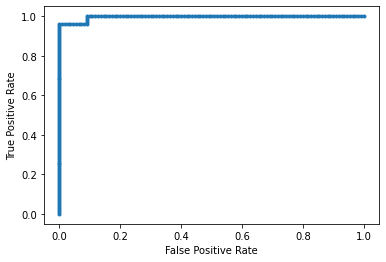

Wrong predictions: 6
Average loss: 0.01519872434437275
Precision: 1.0
Recall: 0.94


In [16]:
evaluation_paths = []
for root, directories, filenames in os.walk('evaluation'):
  for filename in filenames: 
    evaluation_paths.append(os.path.join(root,filename))

evaluation_data = DataGenerator(evaluation_paths, False)
evaluation_data_loader = DataLoader(evaluation_data,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

tot_loss = 0
err = 0
model.eval()

testy = []
prob_fake = []
results = []
false_positive = 0
false_negative = 0
true_positive = 0
true_negative = 0

with torch.no_grad():

  for xb, yb, pathb in evaluation_data_loader:
    model.to(device)
    xb = xb.to(device)
    yb = yb.to(device)

    pred = model(xb)
    loss = loss_func(pred, yb)
    tot_loss += loss
    pred_label = torch.argmax(pred, dim=1)

    yb = yb.cpu().numpy()
    for p, y, p2, x, pb in zip(pred_label, yb, pred, xb, pathb):
      score = F.softmax(p2)
      result = {
          'image_path': pb,
          'true_label': y,
          'predicted_label': p.item(),
          'score_real': score[0].item(),
          'score_fake': score[1].item()
      }
      results.append(result)
      
      # wrong prediction
      if p!=y:
        err = err + 1
        print(f'Wrong prediction - img path: {pb}, Prediction: {score}')
    
        if p:
          false_positive = false_positive + 1
        else:
          false_negative = false_negative + 1
      
      else:
        if p:
          true_positive = true_positive + 1
        else:
          true_negative = true_negative + 1

      # data for ROC
      testy.append(y)
      prob_fake.append(score[1].cpu())

  auc = roc_auc_score(testy, prob_fake)
  print(f'AUC: {auc}')
  fpr, tpr, _ = roc_curve(testy, prob_fake, drop_intermediate=False)
  plt.plot(fpr, tpr, marker='.')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  print(f'Wrong predictions: {err}')
  print(f'Average loss: {tot_loss/len(evaluation_paths)}')
  print(f'Precision: {true_positive / (true_positive + false_positive)}')
  print(f'Recall: {true_positive / (true_positive + false_negative)}')

# write results
test_df = pd.DataFrame(results, columns=['image_path', 'true_label', 'predicted_label', 
                                         'score_real', 'score_fake'])
test_df.to_csv('submission.csv', index=False)